# Exploratory Data Anslysis For Time Series Data

**Approximate Learning time:** Up to 1 hour

---

Before we build any model for any task, the first step is to explore the raw data and understand more about it's peculiarity. 
This exploration can take the form of visualizations or descriptive statistics such as the number of observations, their means, and other statistical measures. 
All of them are geared to gain some intuition behind the data and the task at hand. 

There are standard procedures for exploring time series data, and we will cover those in this notebook. However, remember that nothing can replace your own curiosity. Depending on the dataset you're working with, you may want to explore additional, creative ways to analyze the data.

Specifically, with the help of established python libraries, we will explore the time series datasets through:

- **Raw Data Visualization:** Begin by visualizing the raw time series to get a sense of its **overall behavior and any apparent trends or anomalies**.

- **Summarization:** 
  - *Overall summary*: We'll calculate and discuss basic statistics such as mean, median, variance, and others to summarize the key attributes of the time series. 
  - *Rolling window summary*: We'll also look at **how statistics change temporally** using a rolling window.

- **Correlation Plots:** We'll create autocorrelation plots to visualize **how the time series data points are correlated with each other across time**.

- **Stationarity:** A stationary time series has statistical properties that do not depend on the time at which the series is observed. We will **test whether the statistical properties of our time series remain constant over time or not**.

- **Decomposition:** Time series modeling has traditionally been approached by decomposing it into simpler, more predictable components. A typical decomposition breaks a time series into: (a) **trend**, which represents the overall movement of the time series over a longer period, and (b) **seasonality**, which captures the predictable fluctuations around the general trend. For example, let's say you're analyzing monthly sales data for a company. The trend is the overall growth in sales each year, while the seasonality is the repeating increase and decrease in sales during specific months (like holiday spikes or summer dips). Thus, we'll decompose the time series to **identify and quantify underlying patterns like trends and seasonality**. 

- **Frequency Analysis:** One ingenious way to analyze a time series is through frequency decomposition. Simply put, any time-varying signal can be broken down into its **frequency spectrum**, which reveals the various frequencies present in the signal and their corresponding impact (often depicted by their **power**). By examining a time series in terms of its dominant frequencies, we can gain deeper insights into the underlying patterns. For example, if a frequency of 10 Hz is strong in the series, it suggests that the signal has a strong influence from cycles repeating 10 times per second. However, this may not be immediately apparent just by visually inspecting the raw time series, as other frequencies may be present and mask the influence of this specific frequency.  We'll examine the frequency domain using Fourier analysis to **understand the periodicity of the series**. 

---

## What Does Time Series Data Include?

The minimal requirement for a time series dataset is that it includes **sequentially varying numerical values**. A **time index** specifying the timestamp of each observation is optional but highly useful. If provided, it gives us a sense of the sampling frequency, i.e., the rate at which data is collected. For example, traffic data might be recorded on an hourly basis.

For **multivariate time series**, multiple such time series are included in the dataset, which should be explicitly specified.

Additionally, time series datasets may include other variables (real or categorical):

- **Time-invariant/static features**: These are characteristics that remain constant throughout the entire time series. If present in the dataset, they often appear as columns with the same value for all rows. Such features are useful for multivariate time series modeling.

- **Dynamic features**: These are features that vary over time, just like the target time series. They are essentially time series themselves but are known and available at each time step during the prediction. Think of them as additional features for each time step, while the focus remains on predicting the main target variable. 

---
## Detour: Datasets

Before we begin, it's important to discuss datasets. Advancements in fields like modeling, machine learning, deep learning, and AI have been possible largely due to the availability of standardized datasets that the scientific community can agree upon when sharing ideas and proposals. These datasets have been around for a long time, providing a common foundation for research and comparison.

However, as one might expect, over time, the community can inadvertently overfit its modeling expertise to particular datasets. To address this, the field has evolved by regularly introducing new datasets, encouraging fresh approaches and perspectives. Some are synthetically generated datasets and some are real-world data derived from practical applications. There are plenty to choose from—8,064 univariate and 28 multivariate time series, for example. We will explore a few of them in the initial notebooks and then select a single dataset for modeling purposes. 

There are **two ways to access these datasets**:

- **Manual Access**: A recent work by Qiu et al. (2024) proposed a comprehensive pre-processing and evaluation framework for time series data. This effort has resulted in the creation of a repository of time series datasets, compiled into the `forecasting.zip` file. To minimize the need for pre-processing and maintain simplicity, this will be our primary method for accessing datasets.

- **Through GluonTS**: GluonTS ([documentation](https://ts.gluon.ai/stable/index.html)) is a Python library that houses a variety of time series benchmarks and models in one place. It also provides functionality for building and evaluating models. We will explore this method of accessing datasets in Notebook 1.3.

At this point, it is hard to pintpoint a single source that catalogues where the specific datasets came from. The best way to learn about those datasets is to search online and tracking the research papers which mention them. Each dataset can be recognized by its name, such as "Traffics.csv" or "ETTh1.csv". 

### Manual access 

You can download and prepare the dataset by following these steps:

1. If not already done, download the `forecasting.zip` file from [this link](https://bit.ly/3BdUGVa).
2. Extract the contents into a folder named `forecasting` using the following command:

```bash
unzip forecasting.zip -d forecasting
```

**Note:** 

- The dataset loading function `load_data` (provided by the authors) in `utils_tfb.py` ensures that the index is set as datetime, facilitating easier manipulation in Pandas. However, it's important to note that some datasets might only have a sequential index without proper dates, thus lacking a specific frequency. We will address how to handle such datasets as we proceed.

- Throughout this series, we'll put reusable functions in `utils.py` to streamline data handling and analysis. The abstractions provided by these functions are highly useful in maintaining the smooth flow of the tutorials. You can always refer to them if you'd like to understand their functionality in more detail. All such functions will be prefixed with utils, e.g., `utils.xxx()`.

**References**

- [Qiu et al. 2024, "TFB: Towards Comprehensive and Fair Benchmarking of Time Series Forecasting Methods"](https://arxiv.org/abs/2403.20150)

---

### Setup

In [11]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram

import sys; sys.path.append("../")
import utils_tfb # contains the function to read/preprocess the datasets as provided by the authors

TS_DATA_FOLDER = pathlib.Path("../forecasting").resolve() # Data folder

---
### Datasets to Explore

We will randomly sample a few univariate datasets from the folder and explore them. We will look at multivariate datasets in Notebook 1.2. 

This code block gathers the basic statistics on the datasets, which might take some time. The results are already saved in `dataset_stats.json`.


```python
datasets = []
stats = {
    'n_obs': [],
    'n_features': [],
    'data_file': []
}

for data_file in TS_DATA_FOLDER.iterdir():
    try:
        data = utils_tfb.read_data(str(data_file))
    except:
        continue # some files are not being read properly. Skip them! 

    stats['data_file'].append(str(data_file))
    stats['n_obs'].append(data.shape[0])
    stats['n_features'].append(len(data.columns))


# Write this stat to the disk so that we don't load them again
with open("dataset_stats.json", 'w') as f:
    json.dump(stats, f)
```
---

In [12]:
with open("../dataset_stats.json", 'r') as f:
    stats = json.load(f)

stats['data_file'] = list(map(lambda x: str(TS_DATA_FOLDER / x.split("/")[-1]), stats['data_file']))

MINIMUM_N_OBS = 100
idxs = np.where((np.array(stats['n_obs']) > MINIMUM_N_OBS) * (np.array(stats['n_features']) == 1))
univariate_datasets = [stats['data_file'][idx] for idx in idxs[0]]

idxs = np.where((np.array(stats['n_obs']) > MINIMUM_N_OBS) * (np.array(stats['n_features']) > 1))
multivariate_datasets = [stats['data_file'][idx] for idx in idxs[0]]
n_feats_multivariate = [stats['n_features'][idx] for idx in idxs[0]]


print(f"Number of univariate datasets with more than {MINIMUM_N_OBS} observations: {len(univariate_datasets)}")
print(f"Number of multivariate datasets with more than {MINIMUM_N_OBS} observations: {len(multivariate_datasets)}")
print(f"Number of features in multivariate datasets: {n_feats_multivariate}")
print("Some files: ", list(map(lambda x: x.split("/")[-1], stats['data_file'][:10])))


Number of univariate datasets with more than 100 observations: 4904
Number of multivariate datasets with more than 100 observations: 28
Number of features in multivariate datasets: [11, 11, 948, 11, 7, 7, 7, 7, 321, 8, 107, 7, 207, 5, 111, 5, 325, 307, 170, 137, 862, 21, 2000, 7, 11, 250, 266, 228]
Some files:  ['AQShunyi.csv', 'AQWan.csv', 'Covid-19.csv', 'CzeLan.csv', 'ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv', 'Electricity.csv', 'Exchange.csv']


In [13]:
# Randomly sample a subset of these datasets
n_rows = 5
n_cols = 5

random.seed(1234) # change this to sample different datasets
subset = random.sample(univariate_datasets, k=n_cols * n_rows)

--- 

## Raw Data Visualization

Let's plot the raw data as it is. We will remove the x-labels to avoid cluttering the plots.

Text(0.5, 0.98, 'Time Series Datasets')

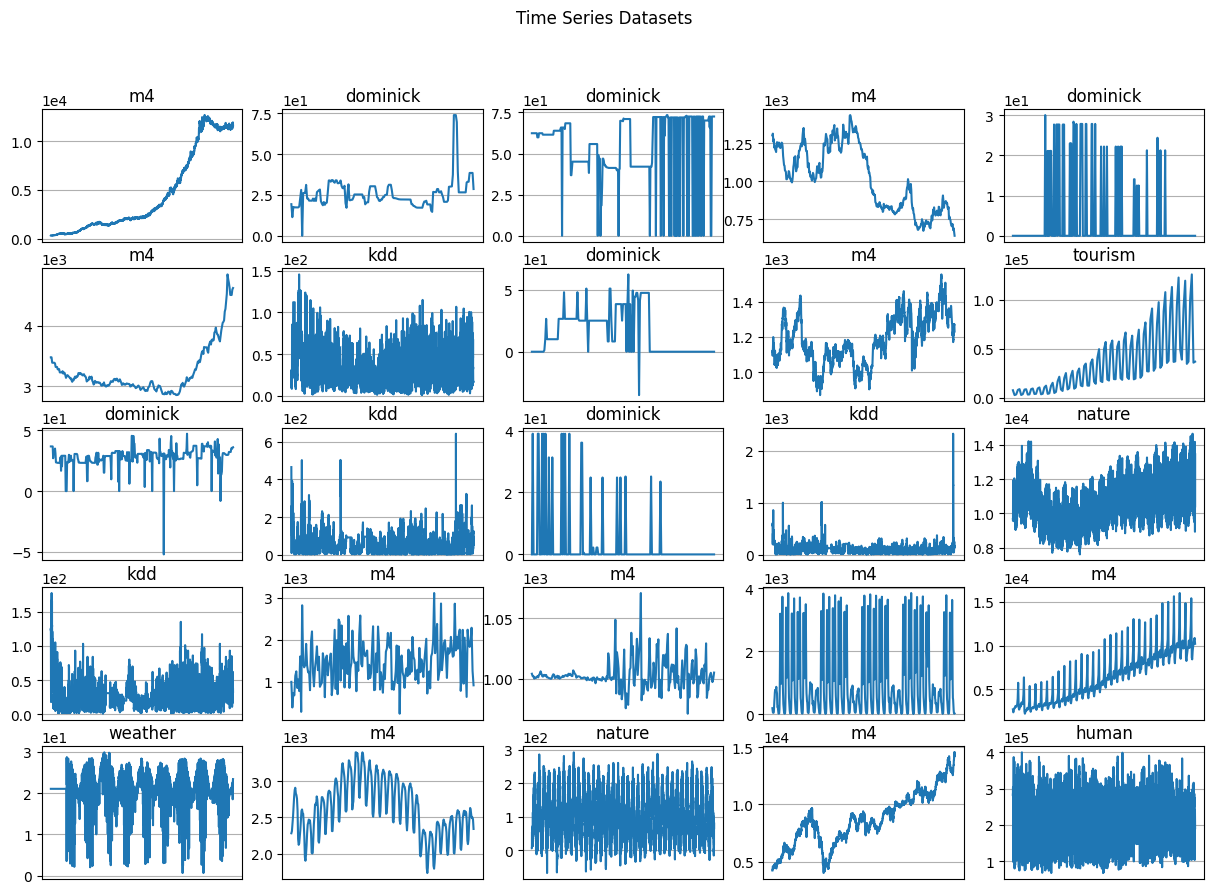

In [14]:
# plot raw observations
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10), dpi=100)

for idx, x in enumerate(subset):
    data = utils_tfb.read_data(x)

    ax = axs[idx % n_rows, idx // n_cols]
    ax.plot(data['channel_1'])
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xticks([])
    ax.set_title(x.split('/')[-1].split('_')[0])
    ax.grid()

fig.suptitle("Time Series Datasets")

**Observations**

- **Range of Y-values:** The datasets exhibit a wide variety of value ranges, highlighting different scales and magnitudes within the data.
  
- **Trend:** Each time series displays unique trends, either increasing, decreasing, or remaining relatively stable over time.

- **Seasonality:** Some series like nature and tourism show clear periodic patterns, indicating seasonality, while others like dominick do not exhibit obvious seasonal effects.

- **Shifts and Transitions:** Series like dominick and m4 (4th row, 3rd column) show instances of sudden shifts in the data points. It becomes necessary to understand the underlying dynamics of such series to help in the modeling. 

- **Stationarity:** The stationarity of the series varies, with some datasets showing stable statistical properties over time (e.g., nature, human) and others demonstrating significant changes in mean and variance.

---

## Summarization

### Descriptive Statistics
These statistics provide a quick overview of the distribution and variability within the dataset. Although it's somewhat unconventional to apply these statistics directly to time series data due to their time-dependent nature, they are still valuable for getting a snapshot of mean, variance, and the range of values. We can also get a sense of these statistics by glancing over the raw data plots. 

---

Let's use `describe` functionality in `pandas` to see statistics of one time series.

In [15]:
for idx, x in enumerate(subset):
    data = utils_tfb.read_data(x)
    print(x)
    print(data['channel_1'].describe())
    break

/Users/gupta/Workspace/tutorials/time_series_v3/forecasting/m4_weekly_dataset_100.csv
count     2296.000000
mean      4449.639656
std       4113.446912
min        288.308000
25%       1437.120000
50%       2183.050000
75%       7479.192500
max      12681.890000
Name: channel_1, dtype: float64


---
### Rolling Statistics

These statistics are computed over a moving window. The result is another time series, which can be better assessed by visualizing. This visualization often helps us to identify trends and patterns. Rolling statistics help in smoothing out noise and revealing underlying trends that might not be visible in the raw data.

---

We will use `rolling` function in `pandas`  to segregate windows of time series, and then compute statistics over those windows.

Let's plot the mean and standard deviation. 

Text(0.5, 0.98, 'Rolling Mean Plots')

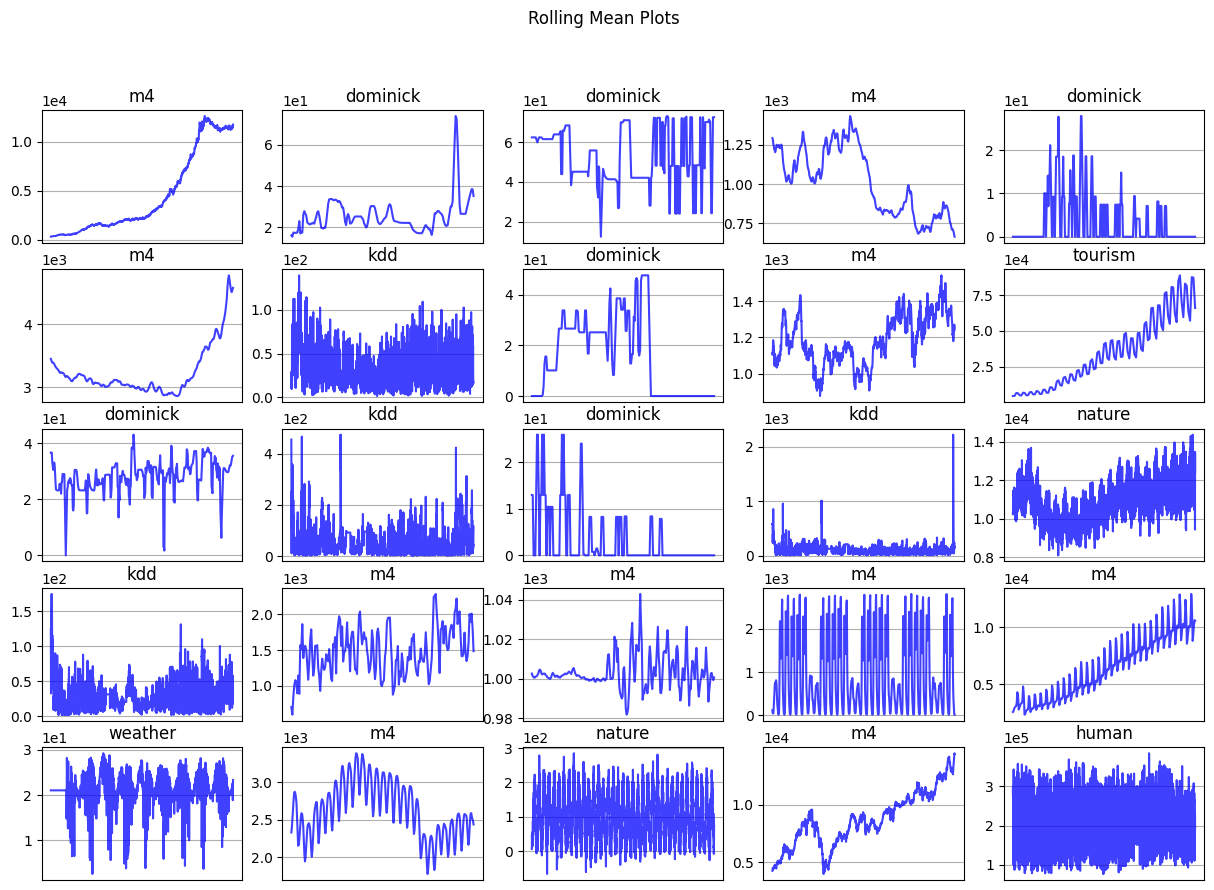

In [16]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10), dpi=100)

lags = np.arange(1, 15)
for idx, x in enumerate(subset):
    ax = axs[idx % n_rows, idx // n_cols]
    
    data = utils_tfb.read_data(x)
    rolling_mean = data['channel_1'].rolling(window=3).mean()
    ax.plot(rolling_mean, color='blue', alpha=0.75, linestyle='-')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_title(x.split('/')[-1].split('_')[0])
    ax.grid()
    ax.set_xticks([])

fig.suptitle("Rolling Mean Plots")

Text(0.5, 0.98, 'Rolling Std Plots')

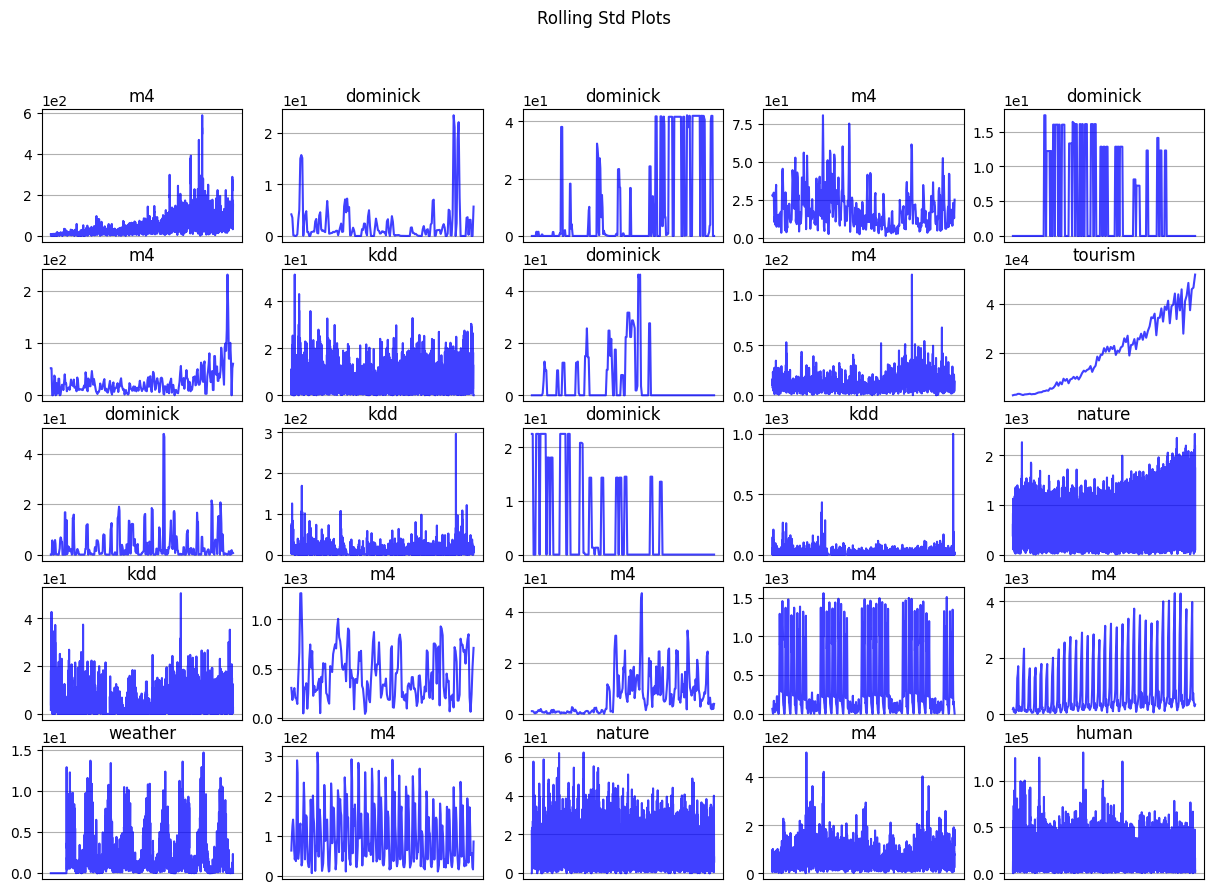

In [17]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10), dpi=100)

lags = np.arange(1, 15)
for idx, x in enumerate(subset):
    ax = axs[idx % n_rows, idx // n_cols]
    
    data = utils_tfb.read_data(x)
    rolling_std = data['channel_1'].rolling(window=3).std()
    ax.plot(rolling_std, color='blue', alpha=0.75, linestyle='-')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_title(x.split('/')[-1].split('_')[0])
    ax.grid()
    ax.set_xticks([])

fig.suptitle("Rolling Std Plots")

**Observations**

Any of the rolling statistics are themselves a time series and therefore can be analyzed or explored using the methods and tools in this noteobook. 

Let's stare at the two plots and make a few observations:

- **Outliers**: The datasets like kdd have a few outlier events as depicted by a peak in their mean and var plot. 
- **Stationarity**: We observe relatively stable trend in standard deviation of some time series (e.g., kdd, nature, human), implying statationarity in the corresponding time series. Later, we will look at a statistical test to concretely establish stationarity of a time series.

---

## Correlation Plots

**Correlation plots** are crucial tools in time series analysis. They help identify dependencies between observations at different time intervals, which is essential for selecting appropriate modeling techniques. Consider a time series mathematically represented as $\{x_t\}_{t=0}^T = \{x_0, x_1, ..., x_T\}$. Two common correlation functions provide insights into the behavior of time series and inform modeling choices:

- **Autocorrelation Function (ACF)**: This measures the correlation between $x_{t-k}$ and $x_t$ for various values of $k = \{1, 2, \dots\}$. It captures the linear relationship between these two values, similar to regressing two values that are $k$ time steps apart.

- **Partial Autocorrelation Function (PACF)**: PACF measures the correlation between $x_{t-k}$ and $x_t$, but with the linear influence of the intermediate values removed. Begin by computing ACF(1), i.e., ACF at lag $k=1$, where PACF(1) = ACF(1). To compute PACF at $k=2$, you calculate the correlation between $x_t - \beta_0 \cdot x_{t-1}$ and $x_{t-2} - \beta_1 \cdot x_{t-1}$, where $\beta_0$ and $\beta_1$ are obtained by linearly regressing $x_t$ on $x_{t-1}$ and $x_{t-2}$ on $x_{t-1}$. This removes the linear influence of the intermediate value.

The prefix "Auto" indicates that the correlation is between values that the same variable gets as the time varies, while the term "function" emphasizes that it is a function of the **lag** $k$.

It is important to remember that **correlation only measures the linear relationship**. If no linear relationship is found, it does not imply that points $k$ time steps apart are unrelated—they may still exhibit a non-linear relationship that linear models cannot capture. This is where deep learning methods excel, as they can model non-linear relationships effectively.

PACF is especially useful for determining the **autoregressive (AR) order** in ARIMA models. For instance, a lag $k$ after which the PACF degrades to zero indicates the appropriate order, as values beyond $k$ lags have no linear influence. However, the choice of $k$ should be reasonable. As noted in STAT462, *"Suppose you have blood pressure readings for every day over the past two years. You may find that an AR(1) or AR(2) model is appropriate for modeling blood pressure. However, the PACF may show a large partial autocorrelation value at a lag of 17, but such a high order for an autoregressive model likely does not make sense."*

--- 

Let's plot the ACFs of the time series in the subset! We will use `pandas`'s `autocorr` functionality to do so.

Text(0.5, 0.98, 'Autocorrelation Plots, Number of lags:15')

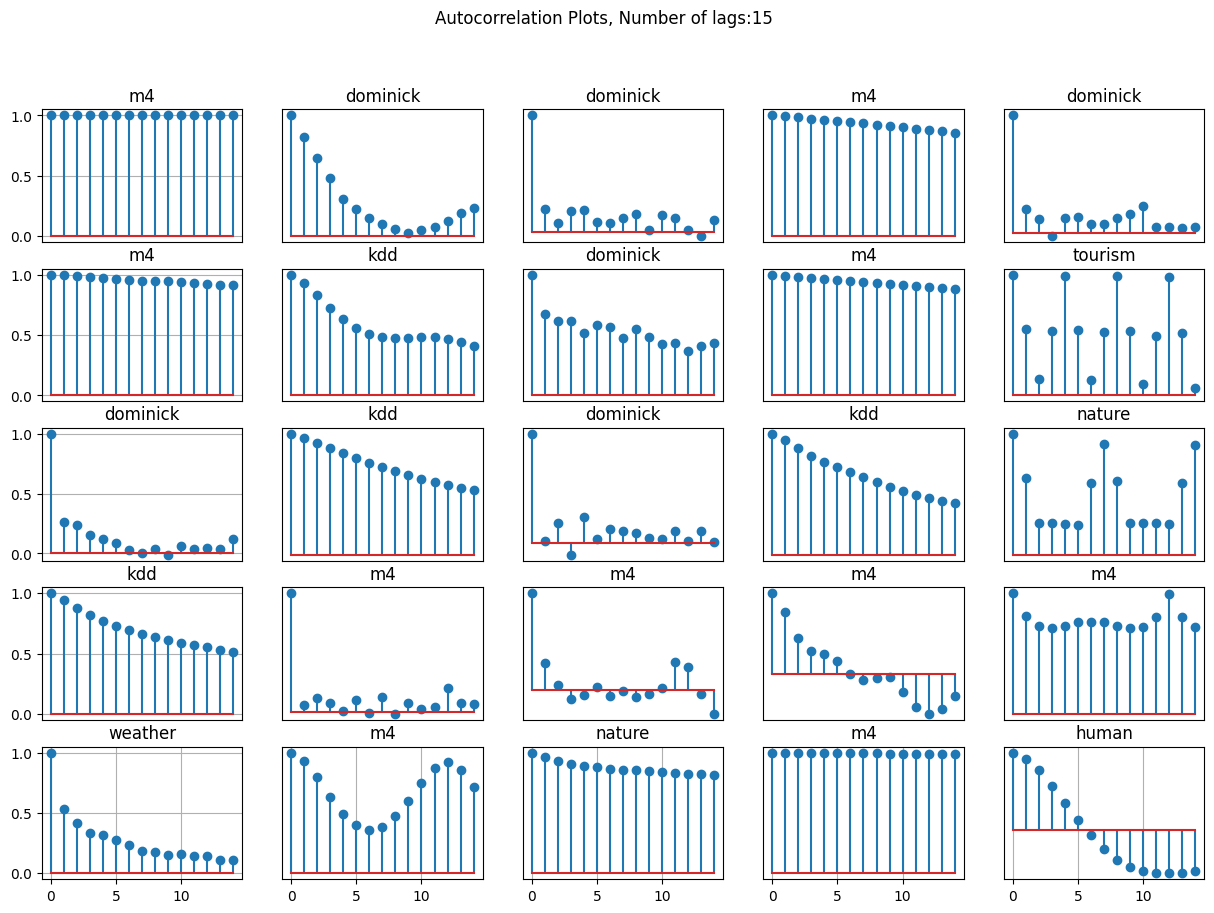

In [18]:
# Autocorrelations
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10), dpi=100)

n_lags = 15
lags = np.arange(0, n_lags)
for idx, x in enumerate(subset):
    ax = axs[idx % n_rows, idx // n_cols]
    
    data = utils_tfb.read_data(x)
    autocorrs = [data['channel_1'].autocorr(lag=lag) for lag in lags]
    ax.stem(lags, autocorrs)
    ax.grid()
    ax.set_title(x.split('/')[-1].split('_')[0])
    if idx // n_cols != 0:
        ax.set_yticks([])

    if idx % n_rows != n_rows-1:
        ax.set_xticks([])

fig.suptitle(f"Autocorrelation Plots, Number of lags:{n_lags}")

**Observations from ACF:** 
- The first value is always 1. This is because that is ACF(0), i.e, correlation of $x_t$ on itself, which should be 1. It is useful to visually determine the decline from the ACF(1) onwards.
- In a lot of plots, ACF values are large over a longer lag. This is mostly due to the linear dependence of the shorter lags not accounted for. We will see that these disappear in PACF plots. 
- Some series like dominick and m4 have a drastic decrease after $k=0$. This is because of rapid fluctuations in the time series. 

---
Let's look at the PACFs of the same! We can use `plot_pacf` from `statsmodels` to do so.

Text(0.5, 0.98, 'Partial Autocorrelation Plots, Number of lags:15')

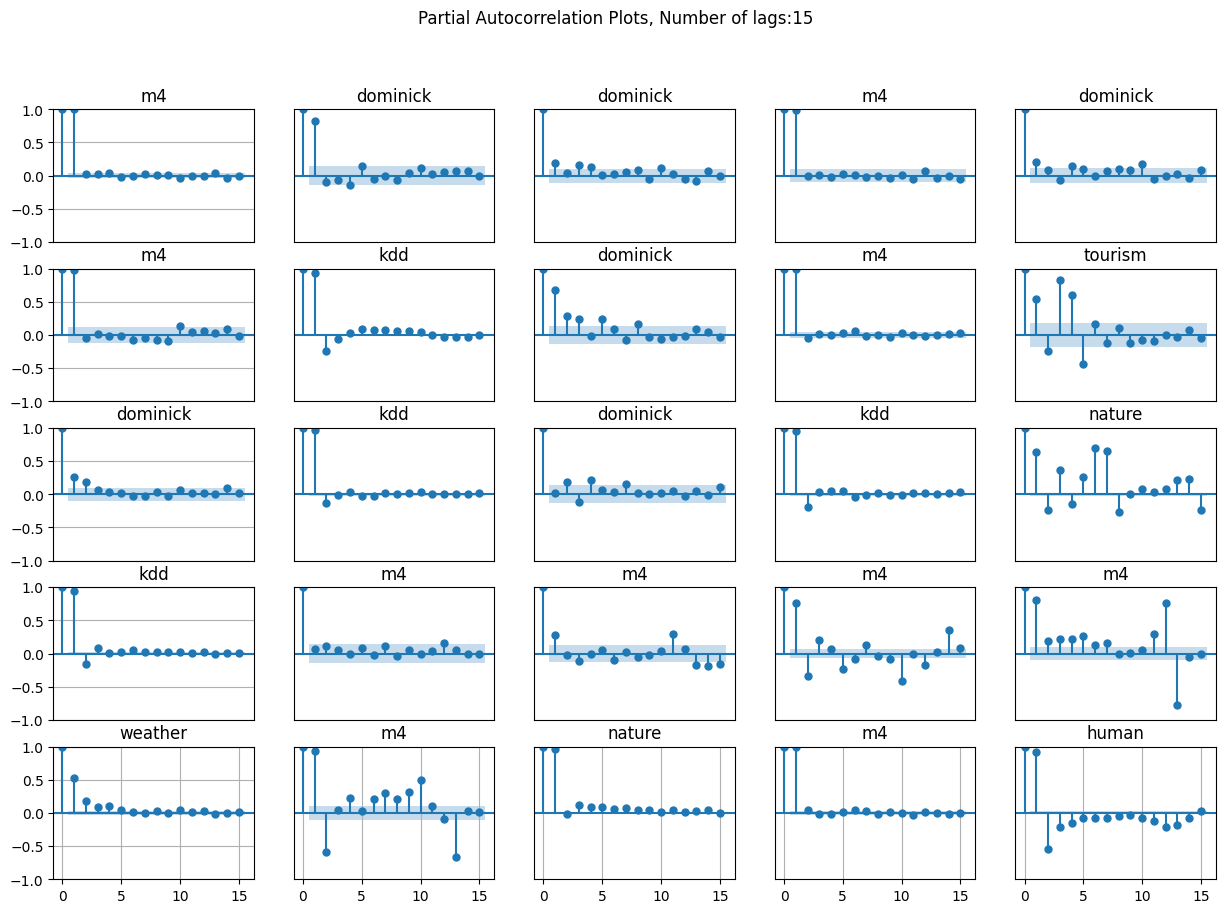

In [19]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10), dpi=100)

n_lags=15
lags = np.arange(0, n_lags)
for idx, x in enumerate(subset):
    ax = axs[idx % n_rows, idx // n_cols]
    
    data = utils_tfb.read_data(x)

    plot_pacf(data['channel_1'], method='ywm', lags=15, ax=ax, title=None)
    ax.grid()
    ax.set_title(x.split('/')[-1].split('_')[0])
    if idx // n_cols != 0:
        ax.set_yticks([])

    if idx % n_rows != n_rows-1:
        ax.set_xticks([])

fig.suptitle(f"Partial Autocorrelation Plots, Number of lags:{n_lags}")

**Observations from PACF:** 

- There is a noticeable decline in correlation as the lag increases. This helps in determining the order of auto-regression parameter($p$ for ARIMA model covered in Module 3), i.e., how many previous observations should be included in the model for optimal forecasting.
- The blue bars represent the **confidence intervals**. Any value beyond these intervals is considered significant and should be taken seriously.
- An autoregressive parameter of 1 would be sufficient for most time series, except for some domains like nature, human behavior, weather, and tourism, which may require higher-order models.

---

## Stationarity

Stationarity is crucial in time series analysis, as many traditional models like ARIMA assume that the time series does not change its statistical properties over time. A stationary series meets the following conditions:

- **Constant Mean:** The average value remains unchanged over time.
- **Constant Variance:** The spread or variability of the values in the series does not change over time.
- **Constant Covariance:** The relationship between intervals in the series remains consistent, regardless of the time at which it is measured.

As a simple example, a constantly upward-moving time series will not have a constant mean. Does that mean it can't be modeled by traditional models? Not necessarily. There are various transformations that can potentially convert a non-stationary time series into a stationary one, making it suitable for traditional modeling techniques. To handle non-stationary data, techniques include:

- **Differencing:** Subtracting the previous observation from the current one. 
- **Seasonal Differencing:** Subtracting the observation from the same season in the previous cycle.
- **Transformation:** Applying logarithmic, square root, or other transformations to stabilize the mean and variance.

These techniques help in modifying the series to meet the assumptions necessary for traditional modeling.

---

Stationarity of a time series is statistically tested using [Augmented Dickey-Fuller Hypothesis Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). This test is also provded in `statsmodels` in `adfuller` function, so let's check which series are stationary. 

**Exercise:** But before you proceed, take a moment to closely examine the plots above and choose the ones you think are stationary. Once you're done, execute the next code block to check your answers :) 

In [20]:
# check stationarity

def testStationarity(x, alpha=0.05):
    results = adfuller(x)
    pvalue = results[1]
    if pvalue < alpha:
        return 1, "Reject the null: the time series is stationary"
    else:
        return 0, "Accept the null: the time series is non-stationary"


stationarity = []
for data_file in subset:
    data = utils_tfb.read_data(data_file)
    stationarity.append(testStationarity(data['channel_1'])[0])


print(f"Number of stationary series in the subset: {sum(stationarity)}")
print("\nStationary time series:\n")
print("\n".join([x.split('/')[-1] for x,y in zip(subset, stationarity) if y]))

Number of stationary series in the subset: 17

Stationary time series:

dominick_dataset_106200.csv
kdd_cup_2018_dataset_without_missing_values_33.csv
weather_dataset_2951.csv
dominick_dataset_95292.csv
kdd_cup_2018_dataset_without_missing_values_227.csv
kdd_cup_2018_dataset_without_missing_values_91.csv
m4_monthly_dataset_5949.csv
dominick_dataset_31722.csv
dominick_dataset_27217.csv
m4_monthly_dataset_44795.csv
nature_75.csv
m4_daily_dataset_3393.csv
kdd_cup_2018_dataset_without_missing_values_38.csv
m4_hourly_dataset_147.csv
dominick_dataset_22523.csv
nature_96.csv
human_84.csv


---
## Series Decomposition

Any time series is decomposable into more predictable components. Depending on the decomposition method used, these components can additively or multiplicatively yield the original time series. Here, we will use STL method to decompose a time series. STL stands for "Seasonal-Trend decomposition procedure based on Loess" (Cleveland et al. 1990). 

STL decomposes a time series $\{x_t\}_{t=0}^T = \{x_0, x_1, ..., x_T\}$ into its trend $T_t$, seasonal $S_t$, and remainder $R_t$ components.

$$X_t = T_t + S_t + R_t$$

Note, multiplicative decomposition is possible by taking logarithmic transformation of the data,

$$ X_t = T_t \cdot S_t \cdot R_t $$

$$ \log X_t = \log T_t + \log S_t + \log R_t $$

Each component plays a different role:

- **Trend, $T_t$:** Represents the long-term progression of the series. It is typically computed by smoothing the data, such as through moving averages or other smoothing techniques, to remove short-term fluctuations and reveal the overall direction of the series.
- **Seasonality, $S_t$:** Indicates predictable patterns that repeat over a specific period. After detrending the series, $X_t - T_t$, the residual series is analyzed for seasonal patterns. While moving averages can help smooth the detrended series, more formal methods like STL are often used to estimate the seasonal component. If the period of seasonality is unclear, the frequency spectrum (discussed next) can be employed to identify the dominant periodic patterns.
- **Residuals, $R_t$:** Comprise the random variations left after trend and seasonality have been accounted for.

**References**

[(Cleveland et al. 1990) STL: a seasonal-trend decomposition procedure based on loess](https://www.wessa.net/download/stl.pdf)

--- 

Let's take two datasets and plot all of their components. We will use `seasonal_decompose` from `statsmodels` to do so. 

Text(0.5, 0.98, 'Trend Seasonality Decomposition')

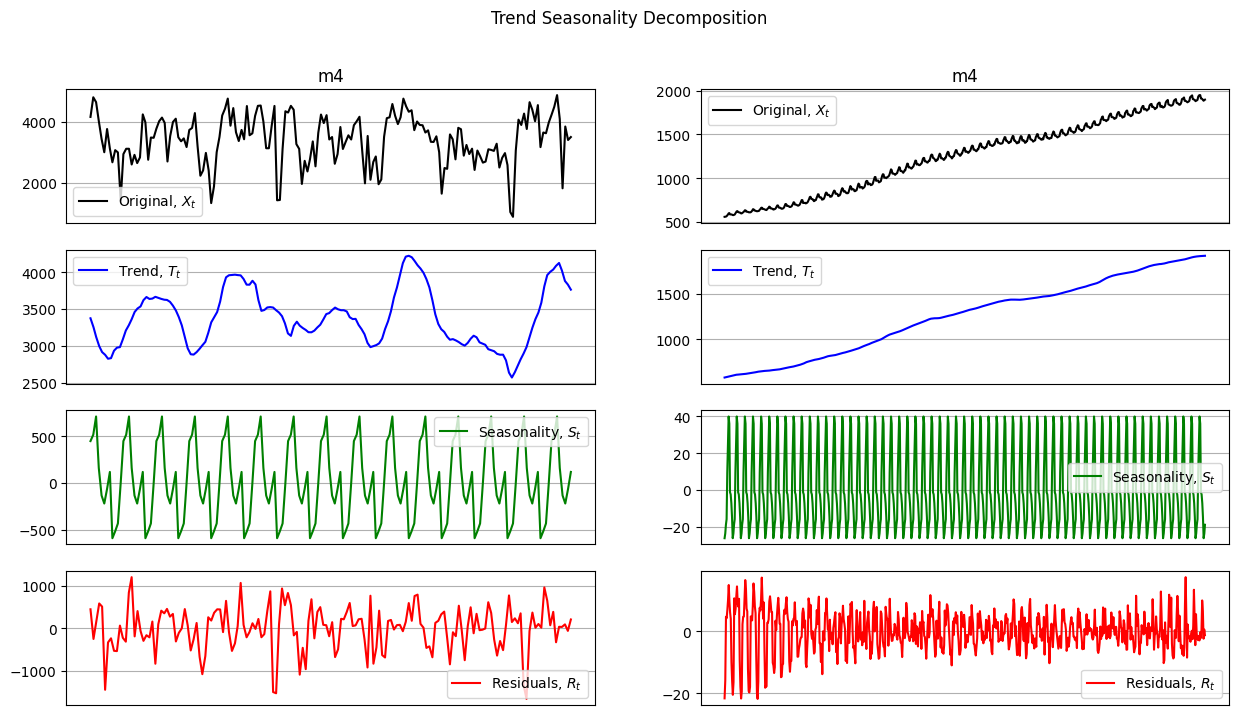

In [21]:
random.seed(234)
subset_seasonality = random.sample(univariate_datasets, k=2)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,8), dpi=100)

for idx, x in enumerate(subset_seasonality):
    row_idx_plot = 0
    col_idx_plot = idx
    data = utils_tfb.read_data(x)

    # original series
    ax = axs[row_idx_plot, col_idx_plot]
    ax.plot(data.channel_1, color='black', label='Original, ' + r'$X_t$')
    ax.legend()
    ax.grid()
    ax.set_xticks([])
    ax.set_title(x.split('/')[-1].split('_')[0])

    result = seasonal_decompose(data.channel_1, model="additive") # Note for some datasets where index frequency is not known, it will result in an error

    # trend
    ax = axs[row_idx_plot + 1, col_idx_plot]
    ax.plot(result.trend, color='blue', label='Trend, ' + r'$T_t$')
    ax.set_xticks([])
    ax.legend()
    ax.grid()


    # seasonality
    ax = axs[row_idx_plot + 2, col_idx_plot]
    ax.plot(result.seasonal, color="green", label=f'Seasonality, ' + r'$S_t$')
    ax.set_xticks([])
    ax.grid()
    
    # plot data - trend
    # ax.plot(data.channel_1 - result.trend, color='gray',  alpha=0.6, label="Detrended, " + r'$X_t - T_t$')
    ax.legend()

    # residual
    ax = axs[row_idx_plot + 3, col_idx_plot]
    ax.plot(result.resid, color="red", label=f'Residuals, ' + r'$R_t$')
    ax.legend()
    ax.set_xticks([])
    ax.grid()

    if idx // n_cols != 0:
        ax.set_yticks([])

    if idx % n_rows != n_rows-1:
        ax.set_xticks([])

fig.suptitle("Trend Seasonality Decomposition")

---
## Frequency Analysis

A **periodogram** is a tool used to estimate and visualize the power (or strength) of different frequencies present in a time series. It provides a way to identify the dominant periodicities by analyzing how much each frequency contributes to the overall variance of the time series. **If a time series has strong periodic behavior, this will show up as peaks at specific frequencies in the periodogram.** Periodogram is computed using Fast Fourier Transform, that converts time series data from the time domain into the frequency domain. We can get deeper into understanding the seasonality of the time series by identifying the hidden periodicities in the data.

---

We will use `scipy`'s `periodogram` to plot the periodograms.

Text(0.5, 0.98, 'Power spectrum')

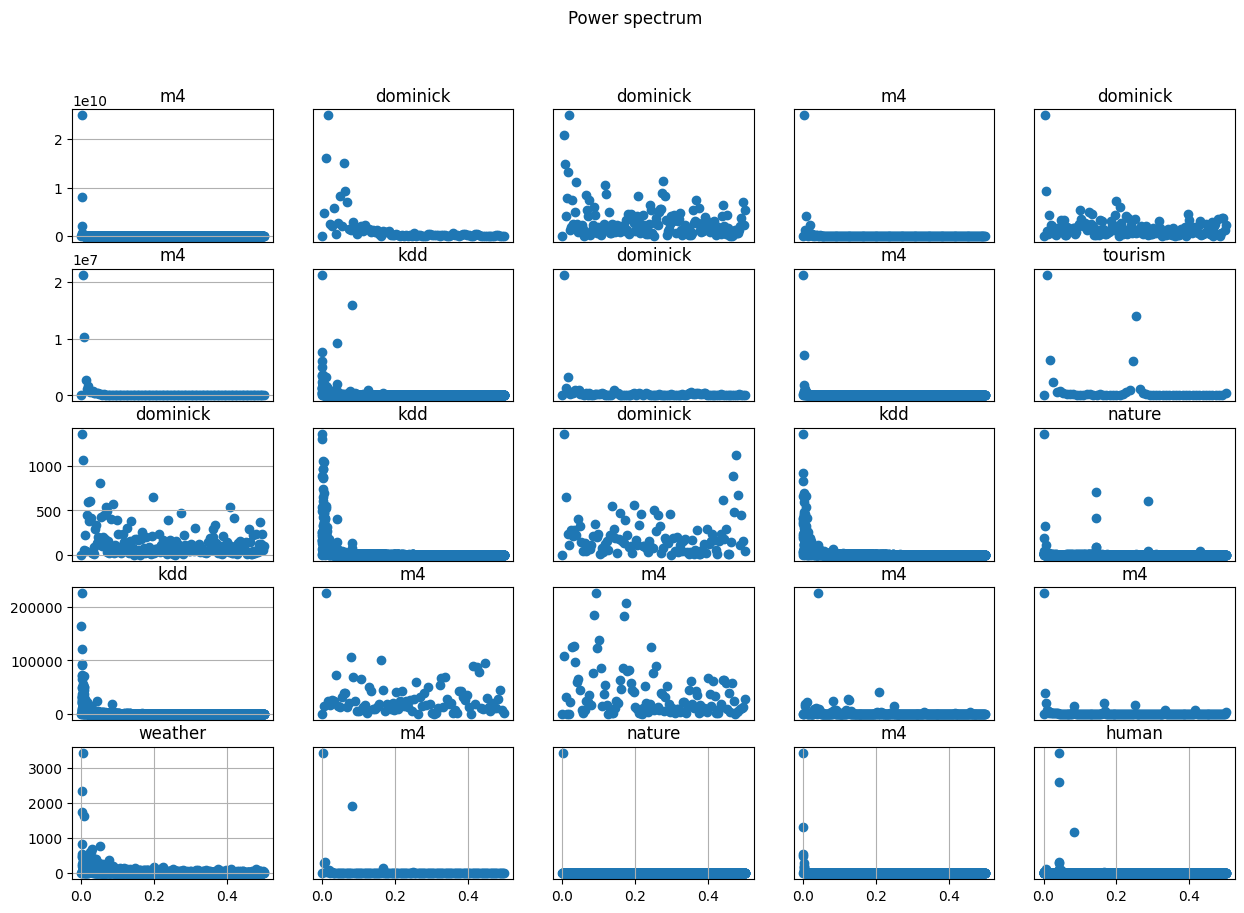

In [22]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10), dpi=100)

for idx, x in enumerate(subset):
    ax = axs[idx % n_rows, idx // n_cols]
    
    data = utils_tfb.read_data(x)
    freqs, power = periodogram(data.channel_1.values)
    ax.scatter(freqs, power)
    ax.grid()
    ax.set_title(x.split('/')[-1].split('_')[0])
    if idx // n_cols != 0:
        ax.set_yticks([])

    if idx % n_rows != n_rows-1:
        ax.set_xticks([])

fig.suptitle("Power spectrum")

---

## Conclusion

We learned about various ways time series data can be explored, both through intutive understanding as well as software tools. 

---

## Next Steps

1. **Focused EDA (Optional):** Proceed to `1.1_datasets-univaraite-eda.ipynb` to analyze a specific univariate dataset in detail, applying the techniques discussed above.
2. **EDA for Multi-variate time series:** Proceed to `1.2_gluonts_datasets.ipynb` to do EDA on multi-variate time series.
3. **Using GluonTS to access datasets:** Proceed to `1.3_gluonts_datasets.ipynb` to explore the GluonTS library, a powerful tool for modeling time series.

---